# Person - data cleaning

This Notebook contains data cleaning and maily deals with the outliers in the dataset.

In [113]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

In [114]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4779, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


### Pre-process data

This analysis will be performed at the daily / hourly level.

I have tried several other approaches (from 15-minute to 3-hour time intervals), but 15 minute intervals are definitely too random and 3 hours reduces the dataset size dramatically. Based on that it seems like hourly analysis (and later forecasting) is a good trade off.

To roll up the data to daily / hourly level we can use Pandas. This is straight forward.

The only issue I have identified with this approach is that it will only include date / hour combinations with observations. But in order to analyse data, gaps without any observations need to be filled with 0's. This is done in the code snippet below.

In [115]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

In [172]:
# use Pandas handy resample feature to fill in gaps with 0's
resampled = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
resampled.columns = ['date_time', 'obs_count']
resampled['date'] = resampled['date_time'].dt.date.astype(str)
resampled['hour'] = resampled['date_time'].dt.hour
resampled = resampled[['date', 'hour', 'obs_count']]

In [173]:
# remove any entries where we know that there was an error in measurements
orig_size = resampled.shape[0]
idx = resampled['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
resampled = resampled.loc[~idx]
print(f'Removed {orig_size - resampled.shape[0]} records')

Removed 72 records


### Distribution

To see a distribution of counts, we can plot a histogram. To make it more interesting for analysis, instead of counts we can actually use the probability density, which tells us the probability of obtaining the distinct counts.

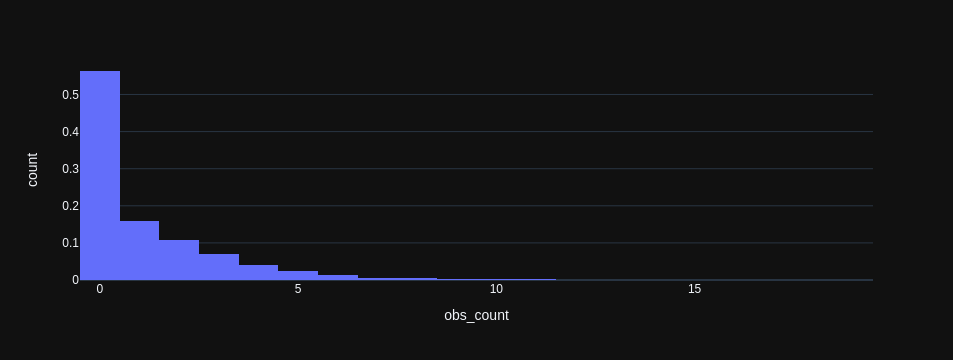

In [174]:
px.histogram(resampled, x="obs_count", height=300, nbins=20, histnorm='probability density')

This data is heavily skewed towards 0's, but this is expected as during the night or when it's dark, the number of objects will be zero and we are not using a night vision camera, and in some time periods there is just not much activity going on.

This is obviously dependant on the location of the system. City center for example would be very busy most of the time.

How does it look when we exclude the zeros?

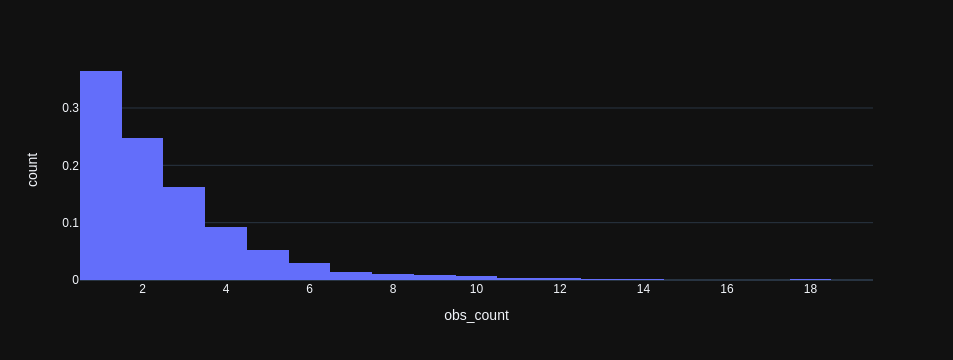

In [175]:
idx = resampled['obs_count'] > 0
px.histogram(resampled[idx], x="obs_count", height=300, nbins=20, histnorm='probability density')

We can see now that only the range within 0-5 or 0-6 observations is really the normal trend. The rest is really an outlier.

### Analyse outliers

What is an outlier in this scenario?

It's a scenario, where within 1 hour time interval, there was much lower or much higher number of observations versus the expected value.

Snippet below generates useful statistics for each hour in the dataset.

In [176]:
# group by hour and generate stats at that level
grouped = resampled.groupby('hour')['obs_count']
stats = grouped.agg(['min', 'max', 'mean', 'median'])

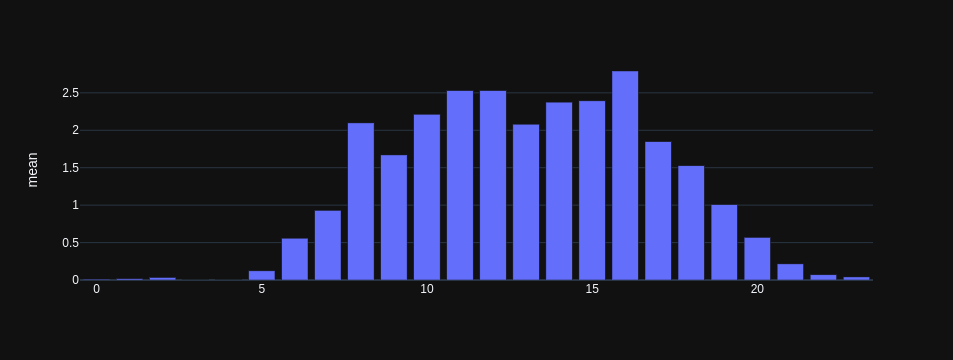

In [177]:
# verify means for each hour
fig = px.bar(stats, y='mean', height=300)
fig.show()

It's clear that the distribution of detections by hour is quite Gaussian, as expected. It is definitely skewed due to outliers, but at this point we are only interested in the overall data distribution.

Now we can draw a box plot for each hour to visualize outliers (it actually uses a median value to calculate the statistics).

Why box plot?

As described at [www.w3resource.com](https://www.w3resource.com/pandas/dataframe/dataframe-boxplot.php):
A box plot is a method for graphically depicting groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to $1.5 * IQR (IQR = Q3 - Q1)$ from the edges of the box. Outlier points are those past the end of the whiskers.

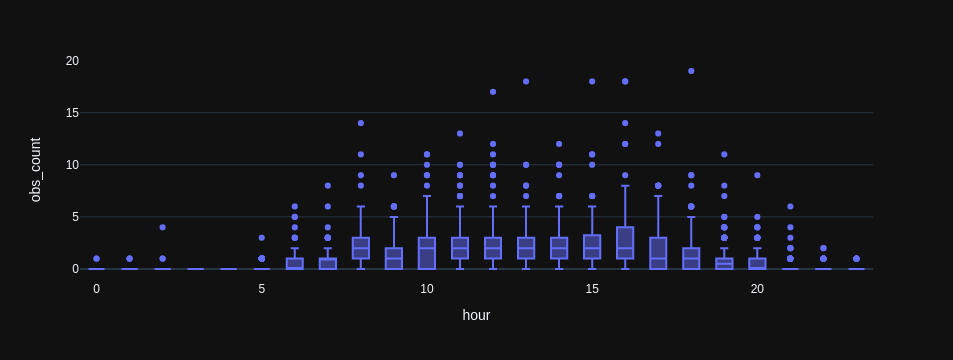

In [178]:
fig = px.box(resampled, x="hour", y="obs_count", height=300)
fig.show()

Boxplots show that there are a lot of significant outliers in the dataset. These should be looked into even deeper to see if there are any gaps in the system.

Outliers can be detected using the IQR method.

The base for the function below can be found in the online [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

Then, once detected we have 2 options:
- remove them from the dataset
- correct them somehow

I am choosing the second option and I will be filling them with the mean average for a particular hour. It is not perfect, but at least we get to keep the observations without breaking the sequence of hourly time intervals. This is important as one can try to use a time series forecasting technique like Recurrent Neural Networks, which require continous sequences.

In [179]:
def find_outlier_params(df_in, col_name, iqr_multiplier=1.5):
    """Calculate outliers based on the interquartile range (IQR)"""
    q1, q3 = df_in[col_name].quantile(0.25), df_in[col_name].quantile(0.75)  # first and third quartiles
    iqr = q3 - q1  # interquartile range
    fence_low, fence_high = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr  # lower and upper bounds
    return iqr, fence_low, fence_high

In [180]:
# fill median stats for each hour
resampled['hourly_median'] = resampled['hour'].map(stats['median'].astype(int))

In [181]:
# initialise values to fill for each hour
resampled['iqr'] = 0
resampled['fence_low'] = 0
resampled['fence_high'] = 0

In [182]:
# initialize column with corrected outliers
resampled['obs_count_corr'] = resampled['obs_count']

In [183]:
# find upper and lower fences for each hour
for name, group in grouped:
    g = pd.DataFrame(group)
    iqr, fence_low, fence_high = find_outlier_params(g, 'obs_count', iqr_multiplier=1.5)
    idx = resampled['hour'] == name
    resampled.loc[idx, 'iqr'] = iqr
    resampled.loc[idx, 'fence_low'] = fence_low
    resampled.loc[idx, 'fence_high'] = fence_high

In [190]:
# we will also update the highest values, which will confuse the model,
# during my experiments I found that the 95% of the targets are the
# most representative, and the rest is only a noise,
# experiments also shown that filling those largest values with the median
# instead of clipping them at the max value generates more accurate forecast
max_count = resampled['obs_count'].quantile(0.95)
print(f'Max count: {max_count}')

Max count: 5.0


In [191]:
# fill values with median
idx = (resampled['obs_count'] < resampled['fence_low']) | (resampled['obs_count'] > resampled['fence_high']) | \
      (resampled['obs_count'] > max_count)
n_outliers = resampled[idx].shape[0]
resampled.loc[idx, 'obs_count_corr'] = resampled[idx]['hourly_median']
print(f'{n_outliers} outliers corrected')

262 outliers corrected


As we can above, a large number of outliers have been corrected with the median hourly values. Now the boxplots look much neater:

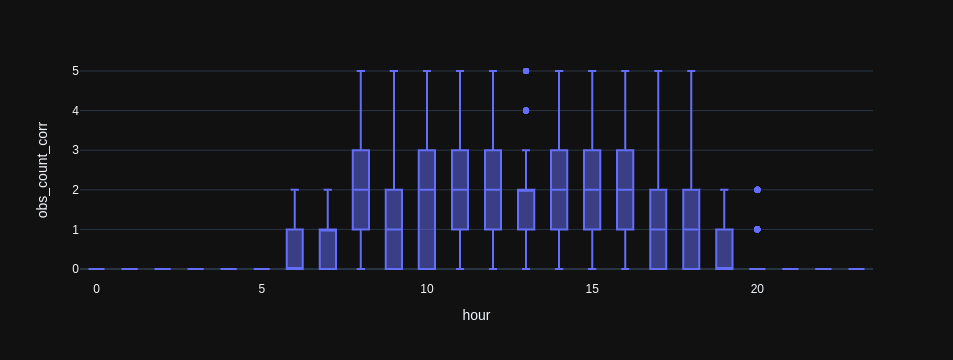

In [192]:
px.box(resampled, x="hour", y="obs_count_corr", height=300)

In [193]:
resampled.head(2)

,date,hour,obs_count,hourly_median,iqr,fence_low,fence_high,obs_count_corr
0,2019-09-09,7,2,1,1.0,-1.5,2.5,2
1,2019-09-09,8,3,2,2.0,-2.0,6.0,3


In [194]:
# save data to csv, so we can conduct feature engineering in another Notebook
use_cols = ['date', 'hour', 'obs_count_corr']
resampled[use_cols].to_csv('../Datasets/Person_no_outliers__2019-09-09_2020-03-02.csv', index=False)